# Artificial Neural Networks (ANN) for Coffee Quality Classification

This notebook demonstrates how to use Artificial Neural Networks (ANNs) to classify coffee quality based on sensory attributes. ANNs are powerful machine learning models that can learn complex patterns in data by mimicking the structure of biological neural networks.

## What are Artificial Neural Networks?

- ANNs consist of interconnected nodes (neurons) organized in layers
- They can learn non-linear relationships between inputs and outputs
- Particularly useful for classification tasks with multiple features
- Can capture complex interactions between sensory attributes

## Learning Objectives

- Understand the structure and components of an ANN
- Build and train a neural network for classification
- Evaluate model performance using accuracy, confusion matrix, and classification reports
- Visualize training history and model architecture
- Interpret results in the context of sensory science

---

## Installation Instructions

Before running this notebook, you must install the required packages. We will use pip or conda to install the necessary libraries.

### Required Packages

Install the core packages using one of the following methods:

**Using pip:**
```bash
pip install pandas numpy scikit-learn tensorflow matplotlib seaborn
```

**Note:** TensorFlow is a large package. If you encounter installation issues, you can install it separately:
```bash
pip install tensorflow
```

**Using conda (Anaconda/Miniconda):**
```bash
conda install pandas numpy scikit-learn matplotlib seaborn
conda install -c conda-forge tensorflow
```

### Optional Packages for Model Visualization

If you want to visualize the neural network architecture, you will also need to install pydot and Graphviz:

**Install pydot:**
```bash
pip install pydot
```

**Install Graphviz (required by pydot):**
- **macOS**: `brew install graphviz`
- **Windows**: Download from https://www.graphviz.org/download/
- **Linux**: `sudo apt-get install graphviz`

---

## Data Credits

This notebook uses the Coffee Quality Data from Kaggle:

**Dataset:** Coffee Quality Data (CQI)  
**Source:** https://www.kaggle.com/datasets/fatihb/coffee-quality-data-cqi  
**Citation:** Fatih B. (2020). Coffee Quality Data. Kaggle. Retrieved from https://www.kaggle.com/datasets/fatihb/coffee-quality-data-cqi

We acknowledge and thank the dataset creator for making this data publicly available for educational and research purposes.

## 1. Import Required Libraries

We will import all necessary libraries for data manipulation, machine learning, neural network construction, and visualization. This includes libraries for handling data (pandas, numpy), machine learning utilities (scikit-learn), deep learning (TensorFlow/Keras), and visualization (matplotlib, seaborn).

In [13]:
# Data manipulation and numerical operations
import pandas as pd
import numpy as np

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Deep learning framework
import tensorflow as tf
from tensorflow.keras import layers, models

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: For model architecture visualization
try:
    from tensorflow.keras.utils import plot_model
    from IPython.display import Image, display
    HAS_PLOT_MODEL = True
except ImportError:
    HAS_PLOT_MODEL = False
    print("Warning: pydot and Graphviz not installed. Model architecture visualization will be skipped.")

# Custom Illinois colors for visualizations
illiniorange = "#FF5F05"
illiniblue = "#13294B"

# Set random seeds for reproducibility
tf.random.set_seed(123)
np.random.seed(123)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


Libraries imported successfully!
TensorFlow version: 2.20.0


## 2. Load and Prepare Data

We will load the coffee quality dataset from the data folder. This dataset contains sensory evaluation scores for various coffee samples. We will select the sensory attributes that will serve as input features for our neural network. These attributes include aroma, flavor, aftertaste, acidity, body, balance, uniformity, clean cup, sweetness, and overall score.


In [14]:
# Load the coffee quality dataset
df = pd.read_csv("data/df_arabica_clean.csv")

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# Define sensory attributes that will be used as predictors
sensory_cols = [
    "Aroma", "Flavor", "Aftertaste", "Acidity",
    "Body", "Balance", "Uniformity", "Clean Cup",
    "Sweetness", "Overall"
]

# Remove rows with missing values in sensory attributes or quality scores
df_sens = df.dropna(subset=sensory_cols + ["Total Cup Points"]).copy()

print(f"\nDataset after removing missing values: {df_sens.shape[0]} samples")
print(f"Number of sensory attributes: {len(sensory_cols)}")
print(f"\nSensory attributes: {sensory_cols}")
print(f"\nQuality score range: {df_sens['Total Cup Points'].min():.2f} to {df_sens['Total Cup Points'].max():.2f}")


Dataset shape: (207, 41)

First few rows:
   Unnamed: 0  ID Country of Origin                 Farm Name  \
0           0   0          Colombia          Finca El Paraiso   
1           1   1            Taiwan  Royal Bean Geisha Estate   
2           2   2              Laos        OKLAO coffee farms   
3           3   3        Costa Rica                 La Cumbre   
4           4   4          Colombia           Finca Santuario   

                                Lot Number                           Mill  \
0                               CQU2022015               Finca El Paraiso   
1  The 2022 Pacific Rim Coffee Summit,T037       Royal Bean Geisha Estate   
2  The 2022 Pacific Rim Coffee Summit,LA01  oklao coffee processing plant   
3                               CQU2022017        La Montana Tarrazu MIll   
4                               CQU2023002                Finca Santuario   

  ICO Number                   Company   Altitude                Region  ...  \
0        NaN      Coffee

### 2.1. Create Quality Classes

We will convert the continuous quality scores (Total Cup Points) into categorical classes. This conversion allows us to use the ANN for classification instead of regression. We will create three quality categories based on industry standards:
- Class 0: Lower quality (scores below 82)
- Class 1: Good quality (scores between 82 and 84.99)
- Class 2: Excellent quality (scores of 85 and above)


In [15]:
# Extract predictor variables (sensory attributes)
X = df_sens[sensory_cols].values
y_cont = df_sens["Total Cup Points"].values

# Define function to convert continuous quality scores to categorical classes
def quality_class(score):
    """
    Convert continuous quality score to categorical class.
    
    Classes:
    - 0: Lower quality (< 82)
    - 1: Good quality (82 - 84.99)
    - 2: Excellent quality (≥ 85)
    """
    if score < 82:
        return 0    # Lower quality
    elif score < 85:
        return 1    # Good quality
    else:
        return 2    # Excellent quality

# Convert continuous scores to categorical classes
y = np.array([quality_class(s) for s in y_cont])

# Display class distribution
unique, counts = np.unique(y, return_counts=True)
class_names = ["<82 (Lower)", "82–84.99 (Good)", "≥85 (Excellent)"]

print("Quality Class Distribution:")
print("="*60)
for cls, count, name in zip(unique, counts, class_names):
    print(f"Class {cls} ({name}): {count} samples ({count/len(y)*100:.1f}%)")
print(f"\nTotal samples: {len(y)}")


Quality Class Distribution:
Class 0 (<82 (Lower)): 28 samples (13.5%)
Class 1 (82–84.99 (Good)): 131 samples (63.3%)
Class 2 (≥85 (Excellent)): 48 samples (23.2%)

Total samples: 207


## 3. Split Data into Training and Testing Sets

We will split the data into training and testing sets. The training set (80% of the data) will be used to train the neural network, while the testing set (20% of the data) will be used to evaluate its performance on unseen data. We use stratification to ensure proportional representation of each quality class in both sets, which helps maintain the class distribution during the split.


In [16]:
# Split data into training (80%) and testing (20%) sets
# stratify ensures proportional representation of classes in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=123
)

print("Data Split Summary:")
print("="*60)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")


Data Split Summary:
Training set: 165 samples
Testing set: 42 samples
Number of features: 10


## 4. Standardize Input Features

Neural networks work best when input features are standardized (mean = 0, standard deviation = 1). Standardization prevents features with larger scales from dominating the learning process. We will fit the scaler on the training data only, and then apply the same transformation to both training and testing sets. This ensures that we do not leak information from the test set into our preprocessing steps.


In [17]:
# Standardize features using StandardScaler
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)  # Fit on training data
X_test_z = scaler.transform(X_test)       # Apply same transformation to test data

print("Feature Standardization Complete:")
print("="*60)
print(f"Training set - Mean: {X_train_z.mean(axis=0).mean():.4f}, Std: {X_train_z.std(axis=0).mean():.4f}")
print(f"Testing set - Mean: {X_test_z.mean(axis=0).mean():.4f}, Std: {X_test_z.std(axis=0).mean():.4f}")
print("\nNote: Standardized features should have mean ≈ 0 and std ≈ 1")


Feature Standardization Complete:
Training set - Mean: 0.0000, Std: 0.8000
Testing set - Mean: -0.0577, Std: 0.7726

Note: Standardized features should have mean ≈ 0 and std ≈ 1


## 5. Build the Artificial Neural Network

We will construct a feedforward neural network with multiple layers. The network architecture consists of:
- **Input layer**: Receives the 10 sensory attributes
- **Hidden layers**: Two dense (fully connected) layers with ReLU activation
  - First hidden layer: 32 neurons
  - Second hidden layer: 16 neurons
- **Output layer**: 3 neurons (one for each quality class) with softmax activation

### Key Components Explained

- **ReLU activation**: Introduces non-linearity, allowing the network to learn complex patterns. ReLU stands for Rectified Linear Unit and helps the network model non-linear relationships.
- **Softmax activation**: Converts raw outputs into probabilities that sum to 1. This allows us to interpret the output as the probability of each quality class.
- **Adam optimizer**: An adaptive learning rate optimization algorithm that adjusts the learning rate during training for better convergence.
- **Sparse categorical crossentropy**: Loss function suitable for multi-class classification when class labels are integers (0, 1, 2) rather than one-hot encoded vectors.


In [21]:
# Define network architecture parameters
n_features = X_train_z.shape[1]  # Number of input features (10 sensory attributes)
n_classes = 3                     # Number of output classes (3 quality levels)

# Build the neural network model
model = models.Sequential([
    # Input layer: receives 10 sensory attributes
    layers.Input(shape=(n_features,)),
    
    # First hidden layer: 32 neurons with ReLU activation
    layers.Dense(32, activation="relu", name="hidden_layer_1"),
    
    # Second hidden layer: 16 neurons with ReLU activation
    layers.Dense(16, activation="relu", name="hidden_layer_2"),
    
    # Output layer: 3 neurons (one per class) with softmax activation
    layers.Dense(n_classes, activation="softmax", name="output_layer")
])

# Compile the model
# - optimizer: Adam (adaptive learning rate)
# - loss: sparse_categorical_crossentropy (for integer class labels)
# - metrics: accuracy (to track during training)
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Display model architecture
print("Neural Network Architecture:")
print("="*60)
model.summary()


Neural Network Architecture:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 931 (3.64 KB)

 Trainable params: 931 (3.64 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Train the Neural Network

We will train the model using the training data. During training, the network learns to map sensory attributes to quality classes by adjusting its weights and biases through a process called backpropagation. We use a validation split (20% of training data) to monitor performance on a held-out portion of the training data, which helps detect overfitting. Overfitting occurs when the model memorizes the training data but fails to generalize to new data.


In [22]:
# Train the model
# - validation_split: 20% of training data used for validation
# - epochs: number of complete passes through the training data
# - batch_size: number of samples processed before updating weights
# - verbose: 0 = silent, 1 = progress bar, 2 = one line per epoch
history = model.fit(
    X_train_z, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=0  # Set to 1 to see training progress
)

print("Training Complete!")
print("="*60)
print(f"Total epochs: {len(history.history['loss'])}")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")


Training Complete!
Total epochs: 100
Final training accuracy: 1.0000
Final validation accuracy: 0.8788


## 7. Evaluate Model Performance

We will evaluate the trained model on the testing set to assess how well it generalizes to unseen data. We will calculate accuracy, generate a confusion matrix, and produce a detailed classification report showing precision, recall, and F1-score for each class. These metrics help us understand not just how accurate the model is overall, but also how well it performs for each individual quality class.


In [23]:
# Evaluate model on test set
test_loss, test_acc = model.evaluate(X_test_z, y_test, verbose=0)

print("Model Performance on Test Set:")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

# Make predictions
y_prob = model.predict(X_test_z, verbose=0)  # Probability predictions
y_pred = y_prob.argmax(axis=1)               # Class predictions (highest probability)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_names_short = ["<82", "82–84.99", "≥85"]

print("\nConfusion Matrix:")
print("="*60)
print("Rows = True labels, Columns = Predicted labels")
print("\n" + pd.DataFrame(cm, index=class_names_short, columns=class_names_short).to_string())

# Generate classification report
print("\nDetailed Classification Report:")
print("="*60)
print(classification_report(
    y_test, y_pred,
    target_names=class_names_short
))


Model Performance on Test Set:
Test Loss: 0.1325
Test Accuracy: 0.9286 (92.86%)

Confusion Matrix:
Rows = True labels, Columns = Predicted labels

          <82  82–84.99  ≥85
<82         5         1    0
82–84.99    0        25    1
≥85         0         1    9

Detailed Classification Report:
              precision    recall  f1-score   support

         <82       1.00      0.83      0.91         6
    82–84.99       0.93      0.96      0.94        26
         ≥85       0.90      0.90      0.90        10

    accuracy                           0.93        42
   macro avg       0.94      0.90      0.92        42
weighted avg       0.93      0.93      0.93        42



## 8. Visualize Model Performance

We will create visualizations to better understand the model's performance. This includes a confusion matrix heatmap to see which classes are being confused with each other, and training history plots to observe how the model learned over time.

### 8.1. Confusion Matrix Visualization

The confusion matrix shows how many samples from each true class were predicted as each class. This helps us identify which classes are being confused with each other. The diagonal elements represent correct predictions, while off-diagonal elements represent misclassifications.


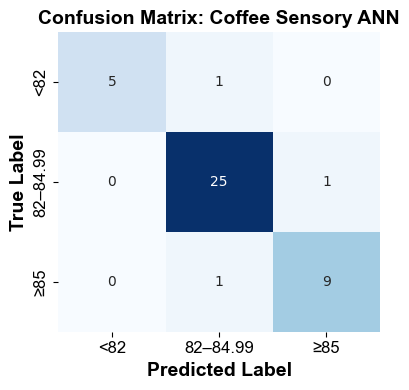

In [24]:
# Create confusion matrix visualization using the confusion matrix already calculated
# Note: cm and y_pred were already computed in the evaluation section above
class_names = ["<82", "82–84.99", "≥85"]

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label", fontsize=14, weight='bold', family="Arial")
plt.ylabel("True Label", fontsize=14, weight='bold', family="Arial")
plt.title("Confusion Matrix: Coffee Sensory ANN", fontsize=14, weight='bold', family="Arial")
plt.xticks(fontsize=12, family="Arial")
plt.yticks(fontsize=12, family="Arial")
plt.tight_layout()
plt.show()


### 8.2. Model Architecture Visualization

We will visualize the neural network architecture to see the structure of our model. This visualization shows the layers, number of neurons in each layer, and how data flows through the network. Note: This requires pydot and Graphviz to be installed (see installation instructions at the beginning of this notebook).



Coffee Sensory ANN Architecture


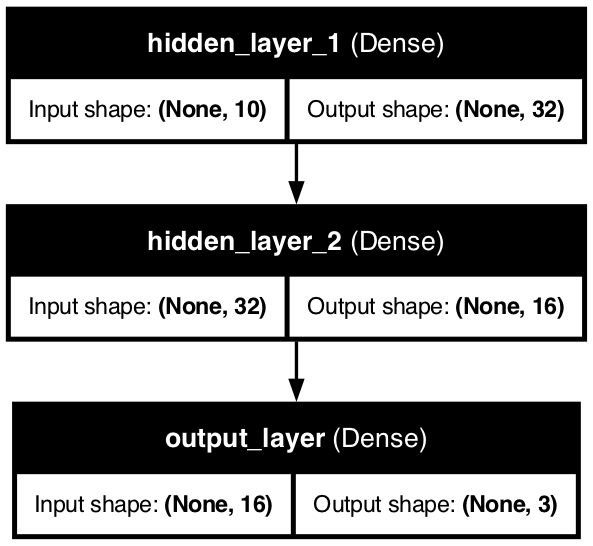

In [25]:
# Visualize and save the model architecture with vertical layers
if HAS_PLOT_MODEL:
    plot_model(
        model,
        to_file="coffee_ann_model.png",
        show_shapes=True,
        show_layer_names=True,
        rankdir="TB",  # Vertical orientation (Top-Bottom) to show layers vertically
        dpi=120,
        expand_nested=True,
        layer_range=None,
    )
    
    # Display the saved model image inline
    print("\nCoffee Sensory ANN Architecture")
    display(Image(filename="coffee_ann_model.png"))
else:
    print("Model architecture visualization skipped. Install pydot and Graphviz to enable this feature.")


### 8.3. Training History Visualization

We will plot the training and validation accuracy and loss over epochs. These plots help us understand how the model learned over time and whether it is overfitting. Overfitting is indicated when training accuracy continues to improve while validation accuracy plateaus or decreases.


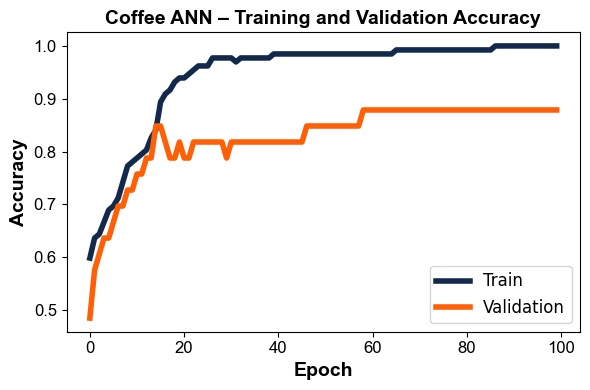

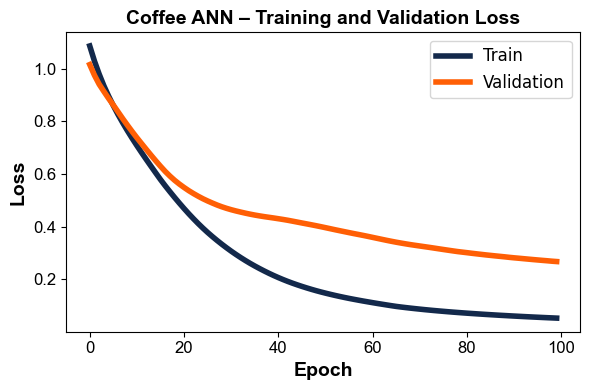

In [26]:
# Plot training and validation accuracy
plt.figure(figsize=(6, 4))
plt.plot(history.history["accuracy"], label="Train", color=illiniblue, linestyle="-", lw=4)
plt.plot(history.history["val_accuracy"], label="Validation", color=illiniorange, linestyle="-", lw=4)
plt.xlabel("Epoch", fontsize=14, weight="bold", family="Arial")
plt.ylabel("Accuracy", fontsize=14, weight="bold", family="Arial")
plt.title("Coffee ANN – Training and Validation Accuracy", fontsize=14, weight="bold", family="Arial")
plt.legend(fontsize=12)
plt.xticks(fontsize=12, family="Arial")
plt.yticks(fontsize=12, family="Arial")
plt.tight_layout()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"], label="Train", color=illiniblue, linestyle="-", lw=4)
plt.plot(history.history["val_loss"], label="Validation", color=illiniorange, linestyle="-", lw=4)
plt.xlabel("Epoch", fontsize=14, weight="bold", family="Arial")
plt.ylabel("Loss", fontsize=14, weight="bold", family="Arial")
plt.title("Coffee ANN – Training and Validation Loss", fontsize=14, weight="bold", family="Arial")
plt.legend(fontsize=12)
plt.xticks(fontsize=12, family="Arial")
plt.yticks(fontsize=12, family="Arial")
plt.tight_layout()
plt.show()


## 9. Interpretation and Conclusions

### Overall Performance

The ANN maps coffee sensory profiles to quality classes very effectively, achieving high accuracy and balanced performance across all three quality levels. The network reaches a test accuracy of 0.93 (93%), which is far above chance (33% for three classes) and comparable to accuracies reported when ANNs are applied to rich analytical fingerprints or electronic-nose data to predict coffee sensory properties.

The macro precision (0.94), recall (0.90), and F1-score (0.92) indicate that the model performs well for each quality class, not just for the majority "82–84.99" category.

### Class-wise Behavior

The mid-quality class (82–84.99) is modeled particularly well, with high recall (0.96) and F1-score (0.94), indicating that almost all samples in this range are correctly identified by the ANN.

Lower-quality (<82) and high-quality (≥85) coffees also show high precision (1.00 and 0.90, respectively) and good recall (0.83 and 0.90, respectively), with only a few samples at the class boundaries being confused with neighboring quality levels.

### Key Takeaways

These results demonstrate that multidimensional sensory scores (aroma, flavor, acidity, body, balance, etc.) contain enough information for a relatively simple feed-forward ANN to recover the cuppers' quality grading with high reliability. This mirrors findings from recent work where ANNs predict coffee traits from complex instrumental data, showing that sensory evaluation data alone can be highly predictive of overall quality classification.
